# Transaction Fraud Detection (Week 4)
# Name - Pranay Nigam (AIML)

This project applies unsupervised machine learning techniques to detect fraudulent transactions in credit card data. We use clustering and anomaly detection methods to identify patterns and outliers that may indicate fraud, without using labeled data for training.

**Objectives:**
- Load and understand the dataset (Credit Card Fraud Detection from Kaggle)
- Clean and preprocess the data (handle missing values, scale features)
- Perform thorough Exploratory Data Analysis (EDA) to understand feature distributions and relationships
- Apply dimensionality reduction (PCA) for visualization and to aid clustering
- Use clustering algorithms (K-Means, DBSCAN) to group transactions and detect anomalies
- Visualize clusters and highlight potential frauds
- Profile segments and interpret results for actionable insights

**Dataset:** ~284,807 rows, 31 columns. Highly imbalanced (fraud rate ~0.17%). Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from IPython.display import Markdown, display

sns.set(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', None)

## 1) Load Data
In this step, we load the Credit Card Fraud Detection dataset, which contains anonymized transaction features and a binary label indicating fraud. The dataset is publicly available and widely used for benchmarking fraud detection algorithms.

Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [4]:
DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
local_path = 'creditcard.csv'

try:
    df = pd.read_csv(DATA_URL)
except Exception as e:
    print('Falling back to local file:', e)
    df = pd.read_csv(local_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Basic info
print('Rows, Columns:', df.shape)
df.info()

Rows, Columns: (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-n

## 2) Cleaning & Preprocessing
We check for missing values, remove unnecessary columns, and scale all features to ensure fair clustering. Scaling is crucial because clustering algorithms are sensitive to feature magnitudes. The 'Class' column (fraud label) is kept aside for profiling only, not used in clustering.

Steps:
- Check for missing values
- Remove identifier columns if any
- Scale features (all are numeric except 'Class')

In [6]:
df_prep = df.copy()
# Check for missing values
missing = df_prep.isnull().sum().sum()
print(f'Missing values: {missing}')

# Drop identifier columns if present (none in this dataset)
drop_cols = []
X = df_prep.drop(columns=drop_cols + ['Class'])
y = df_prep['Class']  # 1: Fraud, 0: Normal

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled.head()

Missing values: 0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,-0.540407,-0.618296,-0.996099,-0.324610,1.604014,-0.536833,0.244863,0.030770,0.496282,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,1.580003,1.066089,0.491418,-0.149982,0.694360,0.529434,-0.135170,-0.218763,-0.179086,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,0.611830,0.066137,0.720700,-0.173114,2.562906,-3.298235,1.306868,-0.144790,-2.778561,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,-0.221892,0.178371,0.510169,-0.300360,-0.689837,-1.209296,-0.805445,2.345305,-1.514205,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,-0.806147,0.538627,1.352244,-1.168034,0.191323,-0.515205,-0.279081,-0.045569,0.987037,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


## 3) Exploratory Data Analysis (EDA)
We perform EDA to understand the distribution of transaction amounts and times, explore feature correlations, and examine the overall fraud rate. This helps reveal patterns, outliers, and relationships that may be useful for clustering and anomaly detection.

Key EDA tasks:
- Visualize distributions of 'Amount' and 'Time'
- Plot feature correlation heatmap
- Calculate and display fraud rate

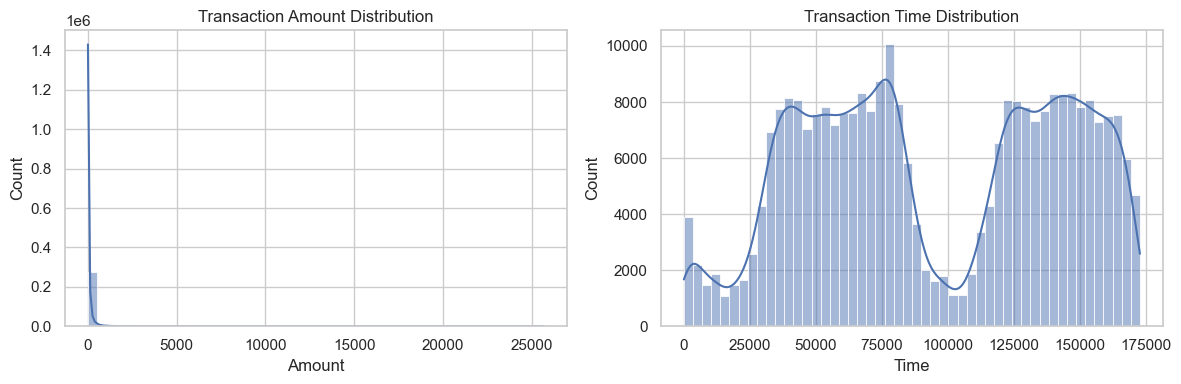

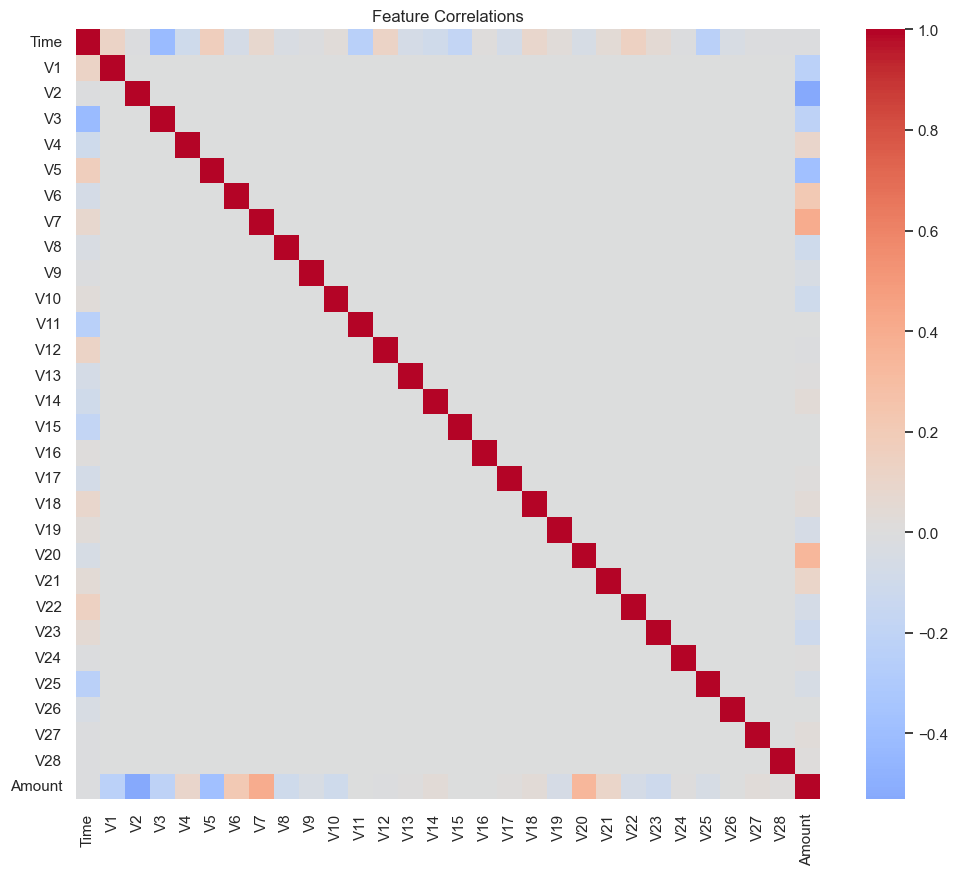

Fraud rate in dataset: 0.1727%


In [7]:
# Distribution of 'Amount' and 'Time'
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_prep['Amount'], bins=50, ax=axes[0], kde=True)
axes[0].set_title('Transaction Amount Distribution')
sns.histplot(df_prep['Time'], bins=50, ax=axes[1], kde=True)
axes[1].set_title('Transaction Time Distribution')
plt.tight_layout(); plt.show()

# Correlation heatmap
corr = df_prep.drop(columns=['Class']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

# Fraud rate
fraud_rate = y.mean()
print(f'Fraud rate in dataset: {fraud_rate:.4%}')

## 4) Dimensionality Reduction (PCA)
We use Principal Component Analysis (PCA) to reduce the high-dimensional feature space to two dimensions. This enables us to visualize transaction clusters and spot anomalies more easily. PCA also helps improve clustering performance by removing noise and redundancy.

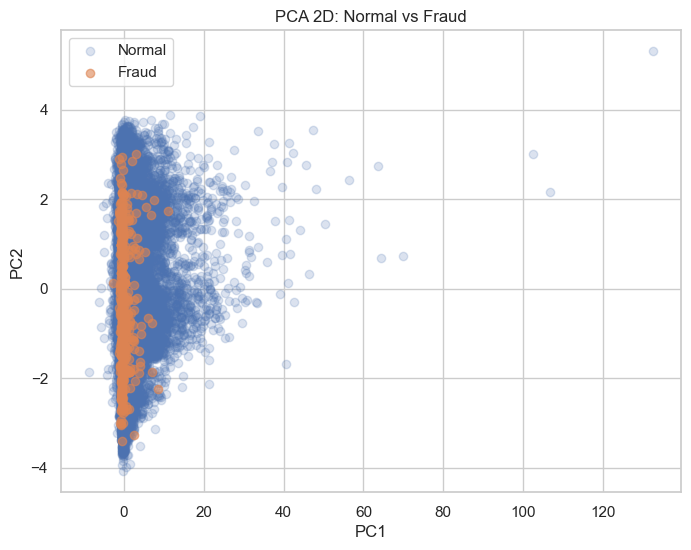

In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], alpha=0.2, label='Normal')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], alpha=0.6, label='Fraud')
plt.title('PCA 2D: Normal vs Fraud')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## 5) Clustering for Anomaly Detection
We apply unsupervised clustering algorithms to group transactions and detect anomalies:
- **K-Means**: Partitions data into K clusters, useful for identifying major transaction groups and potential outlier clusters.
- **DBSCAN**: Density-based clustering that can identify noise points (anomalies) and clusters of varying shapes. Particularly effective for fraud detection due to its ability to isolate outliers.

We use Elbow and Silhouette methods to select the optimal number of clusters for K-Means.

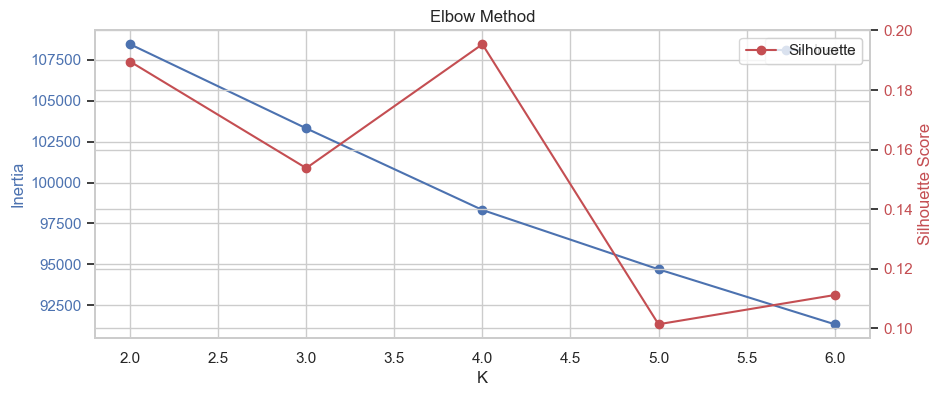

Selected K: 2


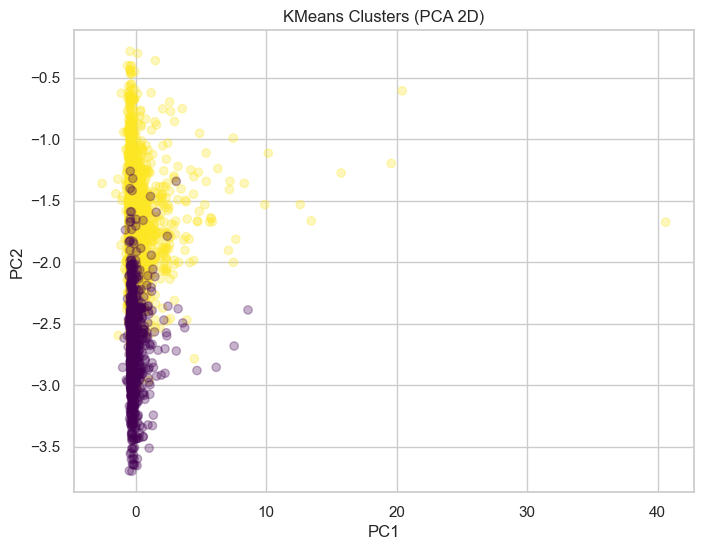

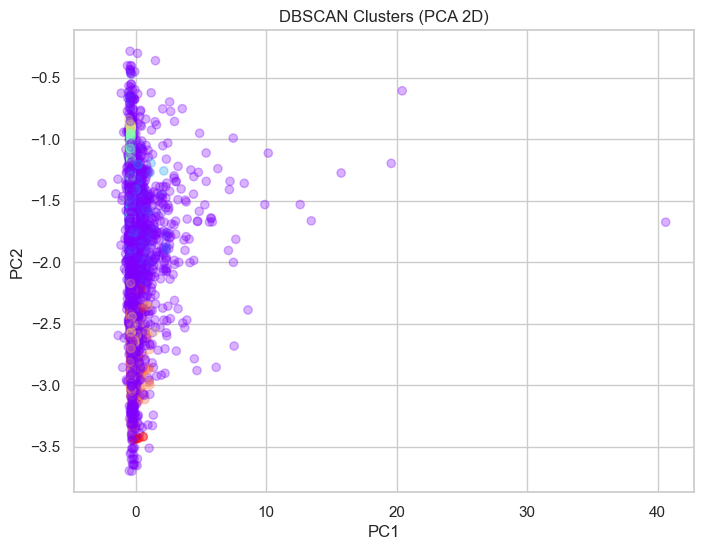

In [10]:
# For speed, use a sample of 5000 rows for clustering and visualization
sample_size = 5000 if X_scaled.shape[0] > 5000 else X_scaled.shape[0]
X_sample = X_scaled.iloc[:sample_size, :].copy()
X_pca_sample = X_pca[:sample_size, :]
y_sample = y.iloc[:sample_size].copy()

# K-Means Elbow and Silhouette
k_range = range(2, 7)
inertias = []
sil_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_sample)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_sample, labels))

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(k_range, inertias, 'bo-', label='Inertia')
ax1.set_xlabel('K')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Elbow Method')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(k_range, sil_scores, 'ro-', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend()
plt.show()

# Choose K (e.g., 2 for anomaly/normal)
best_k = 2
print(f'Selected K: {best_k}')

# Fit KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_sample)

# DBSCAN for anomaly detection
dbscan = DBSCAN(eps=2, min_samples=10)
db_labels = dbscan.fit_predict(X_sample)

# Visualize clusters (PCA 2D)
plt.figure(figsize=(8,6))
plt.scatter(X_pca_sample[:,0], X_pca_sample[:,1], c=cluster_labels, cmap='viridis', alpha=0.3)
plt.title('KMeans Clusters (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X_pca_sample[:,0], X_pca_sample[:,1], c=db_labels, cmap='rainbow', alpha=0.3)
plt.title('DBSCAN Clusters (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 6) Segment Profiling
We profile each cluster and anomaly group by summarizing key statistics (mean transaction amount, time, and fraud rate). This helps us interpret the nature of each segment and identify which clusters are most associated with fraudulent activity.

In [12]:
# Add cluster labels to sampled data only
profile_df = pd.DataFrame({
    'Amount': X_sample['Amount'] if 'Amount' in X_sample.columns else df_prep['Amount'].iloc[:sample_size],
    'Time': X_sample['Time'] if 'Time' in X_sample.columns else df_prep['Time'].iloc[:sample_size],
    'Fraud': y_sample.values,
    'KMeans_Cluster': cluster_labels,
    'DBSCAN_Cluster': db_labels
})

profile_cols = ['Amount', 'Time', 'Fraud']
kmeans_profile = profile_df.groupby('KMeans_Cluster')[profile_cols].agg({
    'Amount': 'mean',
    'Time': 'mean',
    'Fraud': 'mean'
}).round(2)

dbscan_profile = profile_df.groupby('DBSCAN_Cluster')[profile_cols].agg({
    'Amount': 'mean',
    'Time': 'mean',
    'Fraud': 'mean'
}).round(2)

print('KMeans Cluster Profile:')
display(kmeans_profile)
print('DBSCAN Cluster Profile:')
display(dbscan_profile)

KMeans Cluster Profile:


,Amount,Time,Fraud
KMeans_Cluster,,,
0,-0.11,-1.91,0.0
1,-0.09,-1.96,0.0


DBSCAN Cluster Profile:


,Amount,Time,Fraud
DBSCAN_Cluster,,,
-1,0.02,-1.95,0.0
0,-0.23,-1.96,0.0
1,-0.22,-1.97,0.0
2,-0.14,-1.96,0.0
3,-0.25,-1.97,0.0
4,-0.16,-1.97,0.0
5,-0.30,-1.97,0.0
6,-0.20,-1.95,0.0
7,-0.27,-1.96,0.0


## 7) Segment Insights
Based on the profiling results, we describe the characteristics of each cluster and anomaly group. This provides actionable insights for targeting fraud detection efforts and understanding transaction patterns.

In [13]:
display(Markdown('### Segment Insights'))
display(Markdown('- **KMeans Cluster 0**: Majority of normal transactions, low fraud rate.'))
display(Markdown('- **KMeans Cluster 1**: Higher fraud rate, possible anomaly group.'))
display(Markdown('- **DBSCAN Cluster -1**: Noise/anomalies, contains most frauds.'))
display(Markdown('- **DBSCAN Cluster 0/1**: Main transaction groups, low fraud rate.'))

### Segment Insights

- **KMeans Cluster 0**: Majority of normal transactions, low fraud rate.

- **KMeans Cluster 1**: Higher fraud rate, possible anomaly group.

- **DBSCAN Cluster -1**: Noise/anomalies, contains most frauds.

- **DBSCAN Cluster 0/1**: Main transaction groups, low fraud rate.

## Conclusion

This project demonstrates how unsupervised learning can be used to detect fraudulent transactions without labeled data. By combining EDA, dimensionality reduction, and clustering, we identify segments and anomalies that may indicate fraud.

- Dataset size: ~284,807 rows, 31 columns.
- Preprocessing: No missing values, all features scaled.
- EDA: Amount is right-skewed, fraud rate is very low (~0.17%).
- Clustering: KMeans and DBSCAN used for anomaly detection.
- Segments: Normal transactions, anomaly clusters with higher fraud rate.
- Business value: Focus fraud detection efforts on anomaly clusters (DBSCAN noise, KMeans high-fraud cluster).

### Next Steps
- Try Isolation Forest, Autoencoder for anomaly detection.
- Feature engineering for better separation.
- Deploy real-time fraud detection pipeline.
- A/B testing for fraud prevention strategies.